In [55]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm 
import matplotlib.cm as cm
import pandas as pd 

In [56]:
%run "params_paper.ipynb"
%run "gui/model_functions.ipynb" 

#### Plot 1: veel runs van het model

In [10]:
n_results = np.zeros((x, T*P+1))
pd_results = np.zeros((x, T*P))
acting_p_results = np.zeros((x, T*P))
degrees_results = np.zeros((x, P))

for i in tqdm(range(x)):
    n_evolution, z_evolution, zl_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew \
        = model(n, z, P, ne, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, impact, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity)
    n_results[i,:] = n_evolution 
    pd_results[i,:] = pd 
    acting_p_results[i,:] = acting_p  
    degrees_results[i,:] = degrees

100%|██████████| 100/100 [24:19:34<00:00, 875.74s/it]     


In [13]:
# Save data
n_results_df = pd.DataFrame({i:n_results[i,:] for i in range(x)})
n_results_df.to_csv('excel/n_results_df.csv')
pd_results_df = pd.DataFrame({i:pd_results[i,:] for i in range(x)})
pd_results_df.to_csv('excel/pd_results_df.csv')
acting_p_results_df = pd.DataFrame({i:acting_p_results[i,:] for i in range(x)})
acting_p_results_df.to_csv('excel/acting_p_results_df.csv')
degrees_results_df = pd.DataFrame({i:degrees_results[i,:] for i in range(x)})
degrees_results_df.to_csv('excel/degrees_results_df.csv')

In [57]:
n_results_df = pd.read_csv('excel/n_results_df.csv')
n_results = n_results_df.to_numpy().T[1:,:]
pd_results_df = pd.read_csv('excel/pd_results_df.csv')
pd_results = pd_results_df.to_numpy().T[1:,:]
acting_p_results_df = pd.read_csv('excel/acting_p_results_df.csv')
acting_p_results = acting_p_results_df.to_numpy().T[1:,:]
degrees_results_df = pd.read_csv('excel/degrees_results_df.csv')
degrees_results = degrees_results_df.to_numpy().T[1:,:]

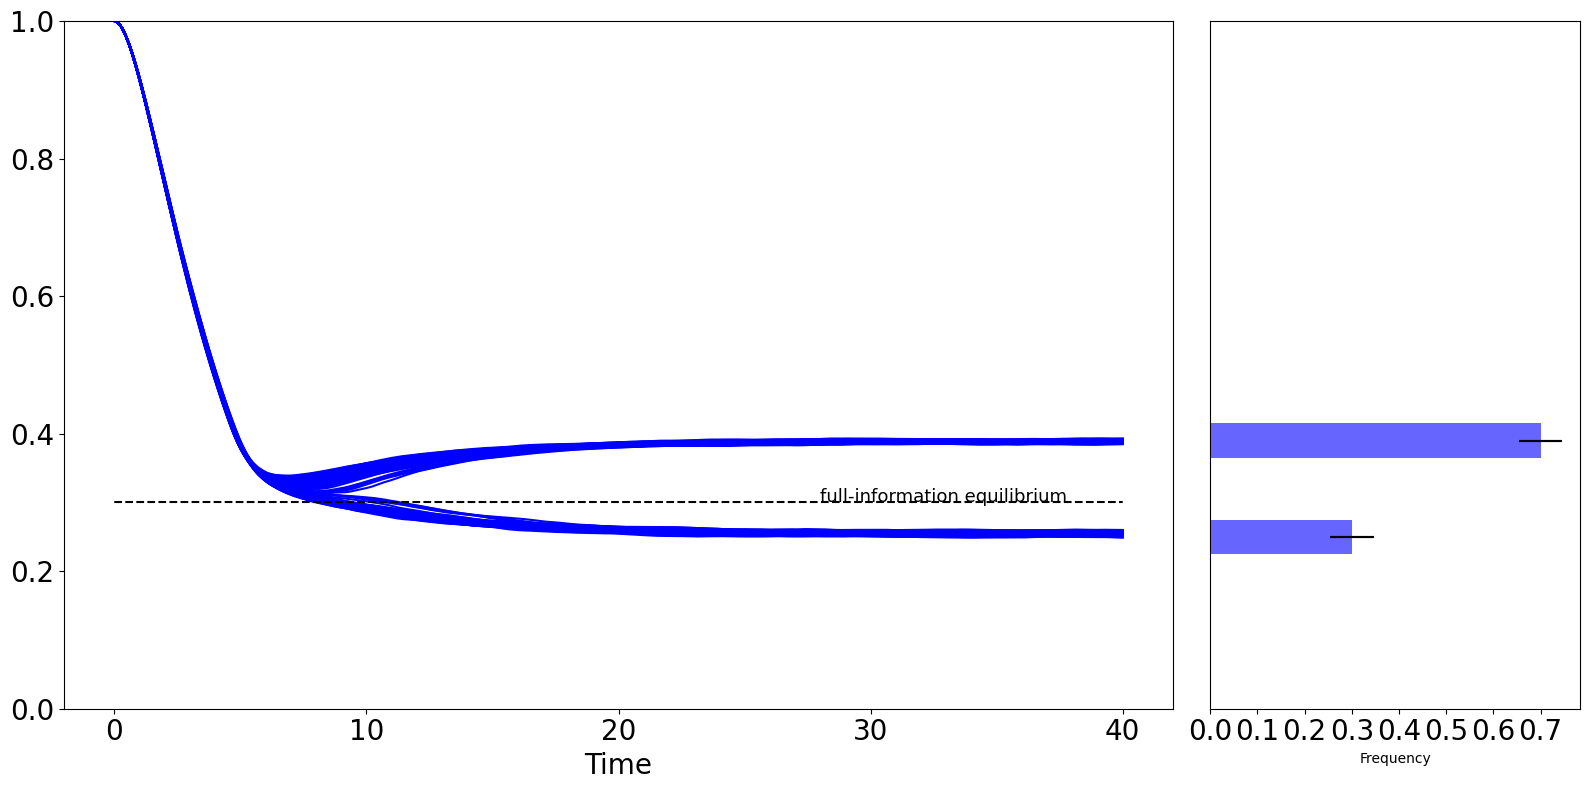

In [28]:
# set up plot
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(1, 2, width_ratios=[12, 4])
BREE1, BREE2 = br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)
y = np.arange(T*P+1)

# subplot with many simulations
plt.subplot(grid[0])
    # plotting
for i in range(x):
    plt.plot(y, n_results[i,:], c='blue')
plt.plot(y, np.ones(T*P+1)*BREE1, c='black', linestyle='dashed')

    # pretty pretty
plt.annotate('full-information equilibrium', xy=(0.7*T, BREE1), xytext=(0.7*T*P, BREE1), fontsize=20)
plt.xticks(np.linspace(0,T*P,5), np.linspace(0,T,5, dtype=int), fontsize=20)
plt.yticks(fontsize=20)
#plt.grid()
plt.xlabel('Generation', fontsize=20)
plt.xlabel('Resource state', fontsize=20)
plt.ylim(0,1)

# bar subplot
plt.subplot(grid[1])
above = np.zeros(x)
for i in range(x):
    ave = np.mean(n_results[i,-100:])
    if ave > BREE1:
        above[i] = 1
plt.barh([0.25,0.39], [1-np.sum(above)/x, np.sum(above)/x], color='blue', height=0.05, alpha=0.6)
prob = np.sum(above)/x
error = np.sqrt(((1-prob) * prob) / (x-1))
plt.errorbar([1-prob, 1-prob], [0.25,0.25], xerr=error, color='black')
plt.errorbar([prob, prob], [0.39,0.39], xerr=error, color='black')
#plt.yticks([0.25, 0.4], ['Scarce', 'Abundant'], fontsize=20, rotation=45)
plt.yticks([])
plt.ylim(0,1)
plt.xticks(fontsize=20)
plt.xlabel('Frequency', fontsize=20)
#plt.grid()

# save and show
plt.tight_layout()
plt.savefig(f'plots/paper/bistability.png', dpi=200)
plt.show()

#### Plot 2: majority illusion

/var/folders/1g/xdw6mj696n1_vgkt7srtq99m0000gn/T/ipykernel_707/443703372.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


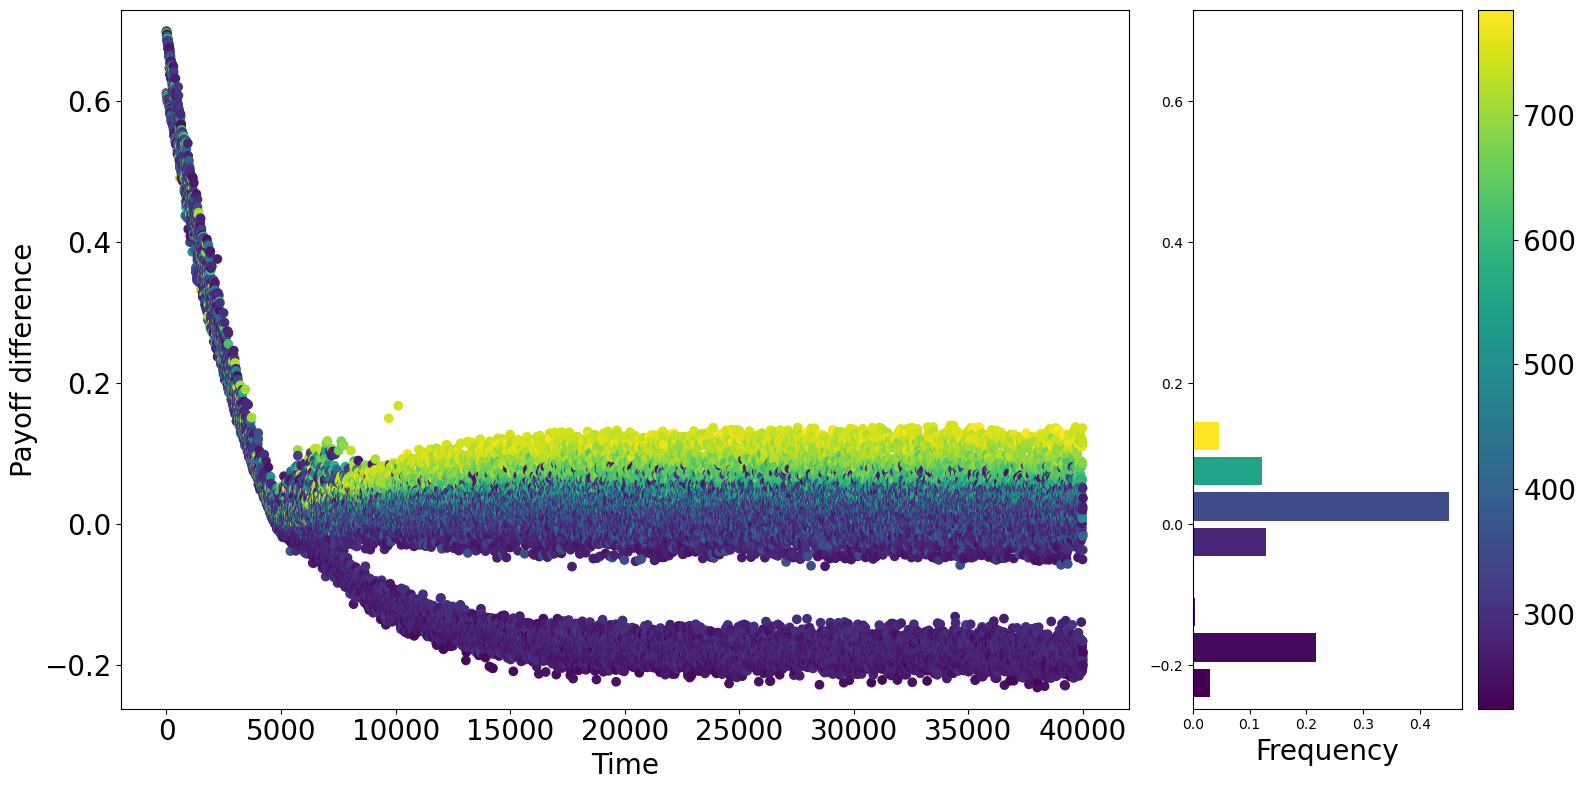

In [30]:
# above average
    # setup
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(1, 2, width_ratios=[3, 1])  # Adjust the width ratios here
ax1 = plt.subplot(grid[0])  # Use the first part of the grid
ax2 = plt.subplot(grid[1])  # Use the second part of the grid

    # take above average results
above_int = above.astype(int)
above_indices = np.where(above_int == 1)[0]
first_above = above_indices[0]

    # subplot with payoff difference
acting_degree = degrees_results[first_above, acting_p_results[first_above, :].astype(int)]
scatter1 = ax1.scatter(np.arange(T*P), pd_results[first_above, :], c=acting_degree)  # Save the scatter object
#ax1.grid()
ax1.set_xlabel('Generation', fontsize=20)
ax1.set_ylabel('Utility advantage', fontsize=20)
ax1.set_xticks(np.linspace(0,T*P,5), np.linspace(0,T,5, dtype=int))
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylim(np.min(pd_results[first_above, :])-0.03, np.max(pd_results[0, :])+0.03)
cbar1 = plt.colorbar(scatter1, ax=ax2)  # Use the scatter object for colorbar
cbar1.ax.tick_params(labelsize=20)

    # calculate frequency per payoff difference and average degree for the second subplot
n_values = 10000
start = T*P - n_values
n_bins = np.ceil((np.max(pd_results[above_indices,-n_values:]) - np.min(pd_results[above_indices,-n_values:])) / 0.05).astype(int) +1
bin_cutoffs = np.linspace(np.min(pd_results[above_indices,-n_values:]), np.max(pd_results[above_indices,-n_values:]), n_bins)
bins = {i:[0, np.array([])] for i in range(n_bins-1)}
for id3, k in enumerate(np.where(above_int == 1)[0]):
    acting_degree = degrees_results[k, acting_p_results[k, :].astype(int)]
    for id1, i in enumerate(pd_results[k,-n_values:]):
        for id2, j in enumerate(bin_cutoffs):
            if i < j:
                bins[id2-1][0] += 1
                bins[id2-1][1] = np.append(bins[id2-1][1], acting_degree[start+id1])
                break
        # hier kan de id1 loop weg --> loop over de bin cutoffs en check met np.where waar de waarden van pd_results[k,-n_values:] daartussen zitten
        # kan dan de count pakken en de acting_degrees op die locaties pakken

    # colors of the bars
mean_values = [np.mean(i[1]) for i in bins.values()]
cmap = cm.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(mean_values), vmax=max(mean_values))
colors = [cmap(normalize(mean)) for mean in mean_values]

    # subplot of the frequencies
ax2.barh([np.mean([bin_cutoffs[i+1], bin_cutoffs[i]]) for i in range(n_bins-1)], [i[0]/(n_values*np.sum(above_int)) for i in bins.values()], height=bin_cutoffs[1] - bin_cutoffs[0] - 0.01, color=colors)
#ax2.grid()
ax2.set_ylim(np.min(pd_results[first_above, :])-0.03, np.max(pd_results[first_above, :])+0.03)
ax2.set_xlabel('Frequency', fontsize=20)

    # save and show
plt.tight_layout()
plt.savefig(f'plots/paper/above_equilibrium_scatter.png', dpi=200)
plt.show()

/var/folders/1g/xdw6mj696n1_vgkt7srtq99m0000gn/T/ipykernel_707/3692438484.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


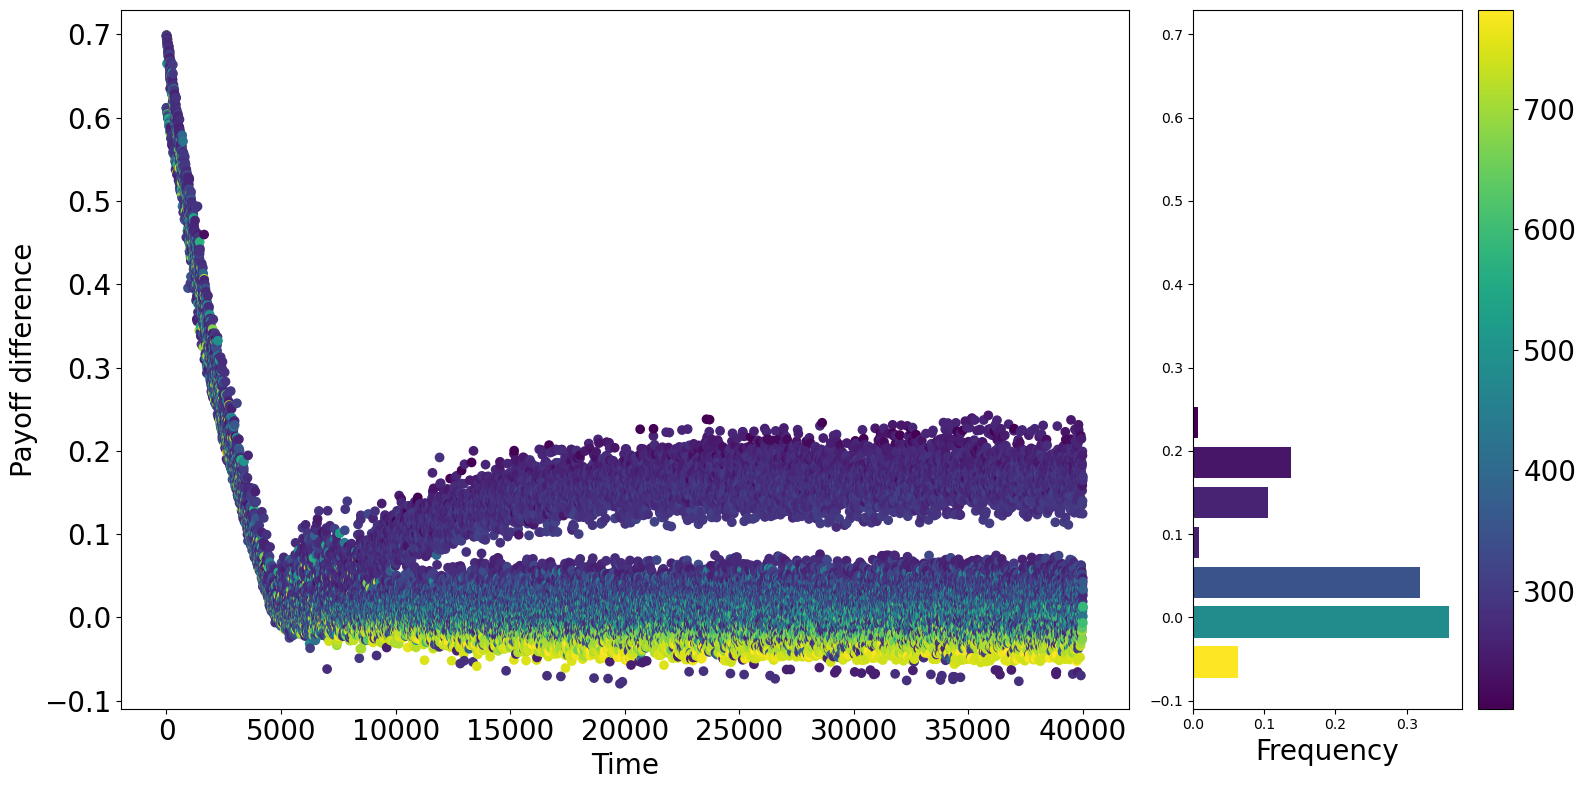

In [31]:
# below average
    # setup
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(1, 2, width_ratios=[3, 1])  # Adjust the width ratios here
ax1 = plt.subplot(grid[0])  # Use the first part of the grid
ax2 = plt.subplot(grid[1])  # Use the second part of the grid

    # take above average results
below_indices = np.where(above_int == 0)[0]
first_below = below_indices[0]

    # subplot with payoff difference
acting_degree = degrees_results[first_below, acting_p_results[first_below, :].astype(int)]
scatter1 = ax1.scatter(np.arange(T*P), pd_results[first_below, :], c=acting_degree)  # Save the scatter object
#ax1.grid()
ax1.set_xlabel('Generation', fontsize=20)
ax1.set_ylabel('Utility advantage', fontsize=20)
ax1.set_xticks(np.linspace(0,T*P,5), np.linspace(0,T,5, dtype=int))
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylim(np.min(pd_results[first_below, :])-0.03, np.max(pd_results[0, :])+0.03)
cbar1 = plt.colorbar(scatter1, ax=ax2)  # Use the scatter object for colorbar
cbar1.ax.tick_params(labelsize=20)

    # calculate frequency per payoff difference and average degree for the second subplot
n_values = 10000
start = T*P - n_values
n_bins = np.ceil((np.max(pd_results[below_indices,-n_values:]) - np.min(pd_results[below_indices,-n_values:])) / 0.05).astype(int) +1
bin_cutoffs = np.linspace(np.min(pd_results[below_indices,-n_values:]), np.max(pd_results[below_indices,-n_values:]), n_bins)
bins = {i:[0, np.array([])] for i in range(n_bins-1)}
for id3, k in enumerate(np.where(above_int == 0)[0]):
    acting_degree = degrees_results[k, acting_p_results[k, :].astype(int)]
    for id1, i in enumerate(pd_results[k,-n_values:]):
        for id2, j in enumerate(bin_cutoffs):
            if i < j:
                bins[id2-1][0] += 1
                bins[id2-1][1] = np.append(bins[id2-1][1], acting_degree[start+id1])
                break
        # hier kan de id1 loop weg --> loop over de bin cutoffs en check met np.where waar de waarden van pd_results[k,-n_values:] daartussen zitten
        # kan dan de count pakken en de acting_degrees op die locaties pakken

    # colors of the bars
mean_values = [np.mean(i[1]) for i in bins.values()]
cmap = cm.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(mean_values), vmax=max(mean_values))
colors = [cmap(normalize(mean)) for mean in mean_values]

    # subplot of the frequencies
ax2.barh([np.mean([bin_cutoffs[i+1], bin_cutoffs[i]]) for i in range(n_bins-1)], [i[0]/(n_values*np.sum(1-above_int)) for i in bins.values()], height=bin_cutoffs[1] - bin_cutoffs[0] - 0.01, color=colors)
#ax2.grid()
ax2.set_ylim(np.min(pd_results[first_below, :])-0.03, np.max(pd_results[first_below, :])+0.03)
ax2.set_xlabel('Frequency', fontsize=20)

    # save and show
plt.tight_layout()
plt.savefig(f'plots/paper/below_equilibrium_scatter.png', dpi=200)
plt.show()

#### Plot 3: effect network parameters

In [32]:
runs = 30
ne_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) 
ne_results = np.zeros((len(ne_array), runs))
skew_results = np.zeros((len(ne_array), runs))

for id1, i in tqdm(enumerate(ne_array)):
    for j in range(runs):    
        i2 = int(i*P)
        n_evolution, z_evolution, zl_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew \
            = model(n, z, P, i2, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, impact, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity)
        ave = np.mean(n_evolution[-100:])
        ne_results[id1, j] = ave 
        skew_results[id1, j] = skew

9it [30:01:30, 12010.06s/it]


In [ ]:
skews = np.zeros(1000)
for i in range(1000):
    A, degrees = gen_net(P, ne)
    skews[i] = calc_moment(degrees, P)
skew250 = np.mean(skews)

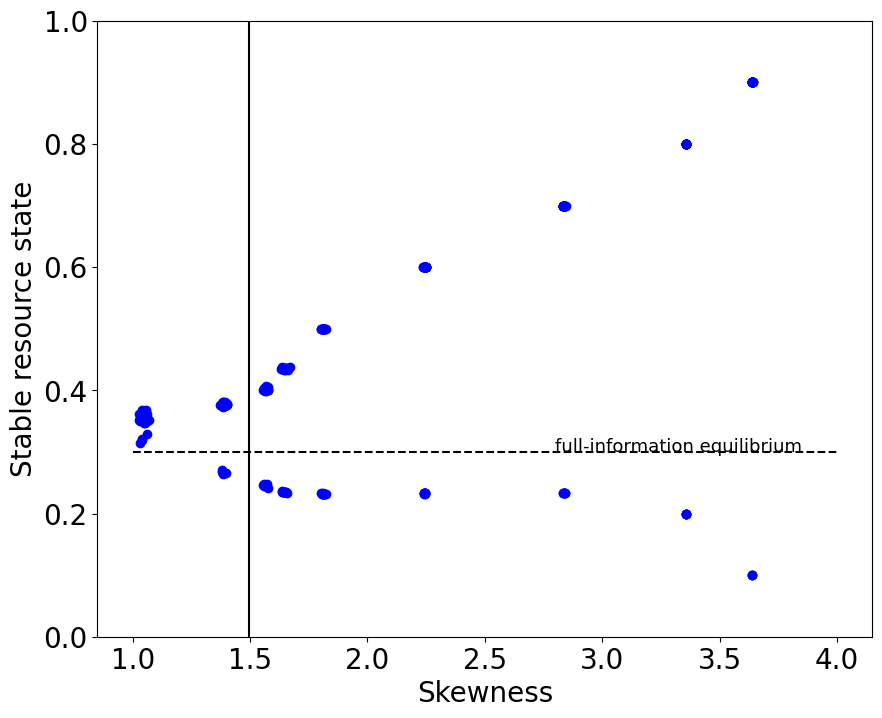

In [45]:
fig = plt.figure(figsize=(10, 8))
for i, x in enumerate(ne_array):
    plt.scatter(skew_results[i,:], ne_results[i,:], c='blue')
plt.plot([1,4], np.ones(2) * br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)[0], c='black', linestyle='dashed')
plt.annotate('full-information equilibrium', xy=(2.8, BREE1), xytext=(2.8, BREE1), fontsize=20)
plt.plot([skew250, skew250], [0, 1], c='black')
#plt.grid()
plt.ylim(0,1)
plt.xlabel('Skewness of the degree distribution', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Stable resource state', fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(f'plots/paper/network_dispersion_v2.png', dpi=200)
plt.show()

#### Plot 4: Voor 1 network density het effect van environmental impact

In [36]:
impact_array = np.array([0, 1, 3, 5, 8]) 
impact_results = np.zeros(((len(impact_array)), runs))

for id1, i in tqdm(enumerate(impact_array)):
    for j in range(runs):    
        n_evolution, z_evolution, zl_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew \
            = model(n, z, P, ne, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, i, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity)
        ave = np.mean(n_evolution[-100:])
        impact_results[id1,j] = ave

0it [00:00, ?it/s]

5it [34:24:21, 24772.32s/it]


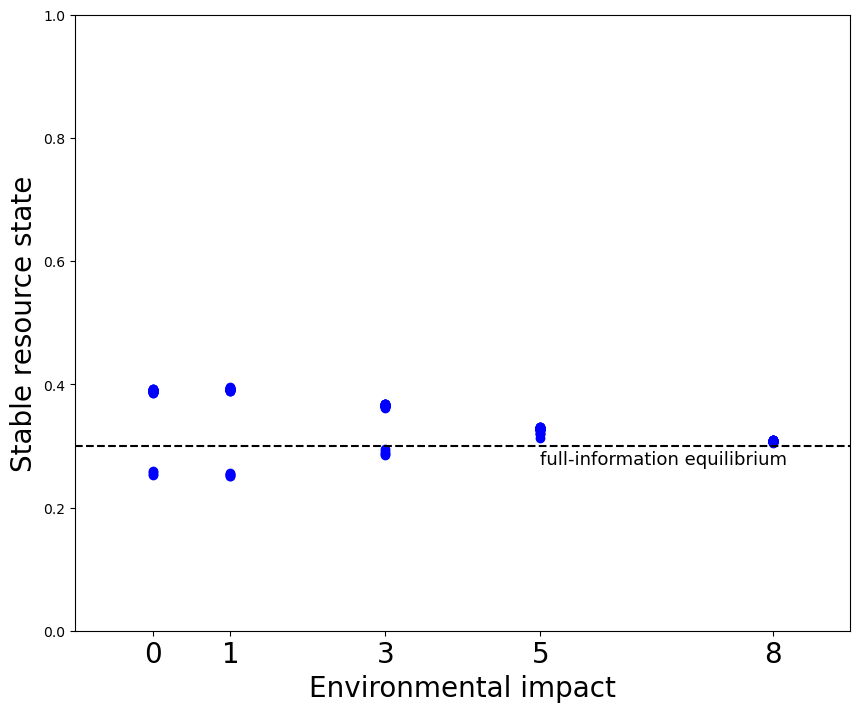

In [43]:
fig = plt.figure(figsize=(10, 8))
for id1, i in enumerate(impact_array):
    plt.scatter(np.ones(runs)*i, impact_results[id1,:], c='blue')
plt.plot(np.arange(start=-1, stop=np.max(impact_array)+2), np.ones(np.max(impact_array)+3) * br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)[0], c='black', linestyle='dashed')
plt.annotate('full-information equilibrium', xy=(5, BREE1-0.03), xytext=(5, BREE1-0.03), fontsize=20)
#plt.grid()
plt.xlabel('Inequality of environmental impact', fontsize=20)
plt.xticks(impact_array, impact_array, fontsize=20)
plt.ylabel('Stable resource state', fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(-1,9)
plt.ylim(0,1)
plt.savefig(f'plots/paper/environmental_impact.png', dpi=200)
plt.show()